In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
data = []
with open('local-results.jsonl') as f:
    for line in f:
        if line.strip():
            data.append(json.loads(line))

In [6]:
all_algorithms = [
    'random_solution',
    'treeGNE', 
    'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    'AOsearchGNE', 
    'OrNE', 
    'BnBOrNE', 
    'BnBOrNEskip'
]

In [46]:
algorithm_rewards = {algorithm: [d[algorithm]['reward'] for d in data] for algorithm in all_algorithms}
algorithm_reward_ratio = {algorithm: [d[algorithm]['reward'] / d['upper_bound'] for d in data] for algorithm in all_algorithms}
algorithm_time = {algorithm: [d[algorithm]['time'] for d in data] for algorithm in all_algorithms}

In [5]:
d_task_nums = [d['task_num'] for d in data]

In [ ]:
d_task_nums = [d['treeGNE'] for d in data]

In [16]:
def independent_t_test(data1, data2):
    # Perform independent t-test
    t_statistic, p_value = stats.ttest_ind(data1, data2)

    # Calculate means and effect size (Cohen's d)
    mean1, mean2 = np.mean(data1), np.mean(data2)
    pooled_std = np.sqrt(
        ((len(data1) - 1) * np.std(data1) ** 2 + (len(data2) - 1) * np.std(data2) ** 2)
        / (len(data1) + len(data2) - 2)
    )
    cohen_d = (mean1 - mean2) / pooled_std

    # Print results
    print("T-statistic:", t_statistic)
    print("P-value:", p_value)
    print("Mean of algorithm 1:", mean1)
    print("Mean of algorithm 2:", mean2)
    print("Cohen's d:", cohen_d)

    # Interpret results
    if p_value < 0.05:
        if mean1 < mean2:
            print("Algorithm 1 is statistically significantly faster than algorithm 2.")
        elif mean2 < mean1:
            print("Algorithm 2 is statistically significantly faster than algorithm 1.")
        else:
            print("Both algorithms have statistically significantly different speeds.")
    else:
        print(
            "No statistically significant difference in speed between the two algorithms."
        )

In [19]:
def mann_whitney_u_test(data1, data2):
    '''
    Perform Mann-Whitney U test (also known as the Wilcoxon rank-sum test
    '''
    statistic, p_value = stats.mannwhitneyu(data1, data2)
    
    # Print results
    print("Mann-Whitney U statistic:", statistic)
    print("P-value:", p_value)
    
    # Compare medians if there is a significant difference in distributions
    if p_value < 0.05:
        median1 = np.median(data1)
        median2 = np.median(data2)
        print("Median of algorithm 1:", median1)
        print("Median of algorithm 2:", median2)
        if median1 < median2:
            print("Algorithm 1 has a significantly faster median execution time.")
        elif median2 < median1:
            print("Algorithm 2 has a significantly faster median execution time.")
        else:
            print("Both algorithms have statistically significantly different medians.")
    else:
        print("No statistically significant difference in distributions.")

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def compare_and_plot_algorithms(algorithm_values):
    def compare_algorithms(algorithm_values):
        algorithms = list(algorithm_values.keys())
        n = len(algorithms)
        
        # Calculate mean execution times and sort algorithms by mean execution time
        mean_execution_times = {algorithm: np.mean(times) for algorithm, times in algorithm_values.items()}
        sorted_algorithms = sorted(algorithms, key=lambda x: mean_execution_times[x])

        matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i+1, n):
                algorithm1_name = sorted_algorithms[i]
                algorithm2_name = sorted_algorithms[j]

                algorithm1_times = algorithm_values[algorithm1_name]
                algorithm2_times = algorithm_values[algorithm2_name]

                # Perform independent t-test
                t_statistic, p_value = stats.ttest_ind(algorithm1_times, algorithm2_times)

                # Store p-value in the matrix
                matrix[i][j] = p_value
                matrix[j][i] = p_value  # Since the t-test is symmetric, we fill both (i,j) and (j,i)

        return matrix, sorted_algorithms

    def plot_comparison_matrix(matrix, algorithms_mean):
        fig, ax = plt.subplots()
        im = ax.imshow(matrix, cmap='viridis')

        # Set labels
        ax.set_xticks(np.arange(len(algorithms_mean)))
        ax.set_yticks(np.arange(len(algorithms_mean)))
        ax.set_xticklabels(algorithms_mean)
        ax.set_yticklabels(algorithms_mean)

        # Rotate the tick labels and set their alignment.
        ax.xaxis.tick_top()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(len(algorithms_mean)):
            for j in range(len(algorithms_mean)):
                p_value = matrix[i, j]
                # if p_value < 0.05:
                if algorithm_values[algorithms_mean[i]] < algorithm_values[algorithms_mean[j]]:
                    color = 'blue'  # Algorithm i is faster
                elif algorithm_values[algorithms_mean[i]] > algorithm_values[algorithms_mean[j]]:
                    color = 'red'   # Algorithm j is faster
                else:
                    color = 'black'
                # else:
                #     color = 'white'

                text = ax.text(j, i, f'{p_value:.2f}', ha="center", va="center", color=color)

        ax.set_title("Comparison Matrix")
        # Put x label on top, rotate the tick labels, put the x-axis labels at the top of the tick marks
        # ax.xaxis.tick_top()
        # plt.xticks(rotation=45, ha="left")
        
        # # ax.xaxis.set_label_position('top')
        # ax.xaxis.tick_top()
        # plt.xticks(rotation=45)
        # plt.xlabel("Algorithm")
        
        fig.tight_layout()
        plt.show()

    # Compare algorithms
    comparison_matrix, algorithms_mean = compare_algorithms(algorithm_values)

    # Plot comparison matrix
    plot_comparison_matrix(comparison_matrix, algorithms_mean)



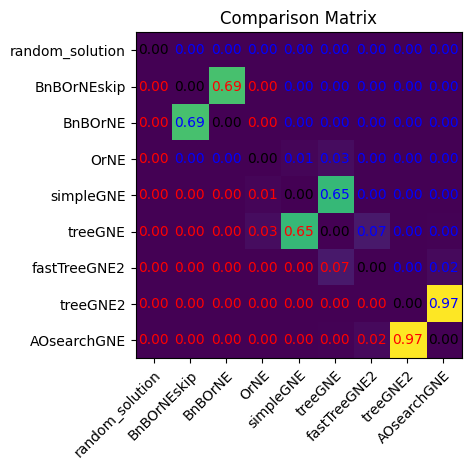

In [60]:
compare_and_plot_algorithms(algorithm_time)

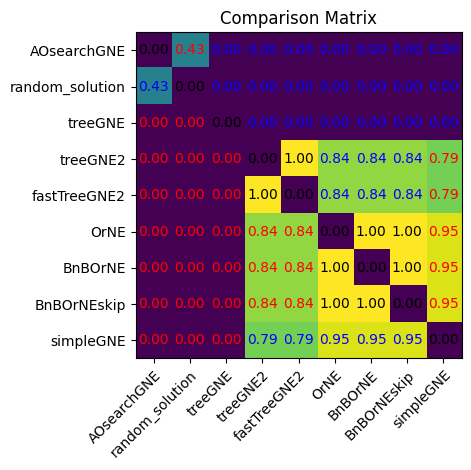

In [61]:
compare_and_plot_algorithms(algorithm_rewards)

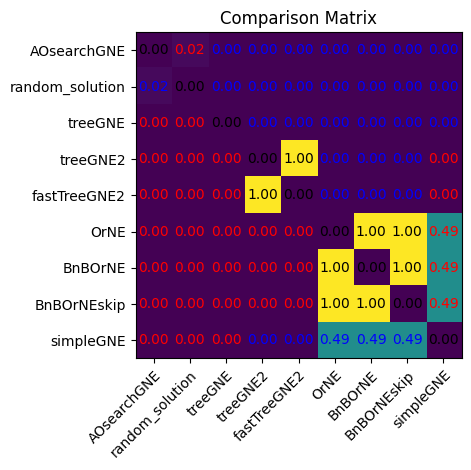

In [62]:
compare_and_plot_algorithms(algorithm_reward_ratio)

In [22]:

# Example data (execution times for two algorithms)
# algorithm1_times = algorithm1_speed
# algorithm2_times = algorithm2_speed

# Perform independent t-test
# independent_t_test(algorithm_time['treeGNE2'], algorithm_time['fastTreeGNE2'])
mann_whitney_u_test(algorithm_time['BnBOrNE'], algorithm_time['fastTreeGNE2'])


Mann-Whitney U statistic: 446153.0
P-value: 2.26382601463086e-125
Median of algorithm 1: 4.444501100020716
Median of algorithm 2: 22.44565780000994
Algorithm 1 has a significantly faster median execution time.


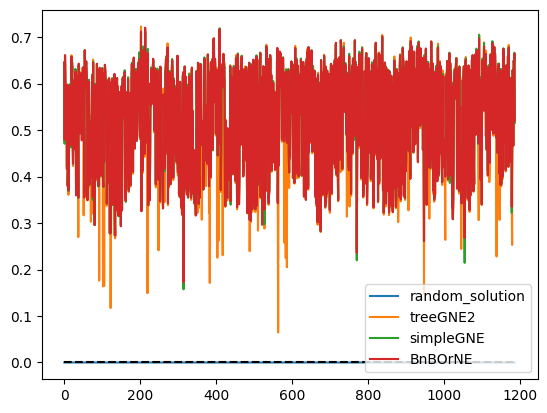

In [4]:
# Create a line chart of the reward for each algorithm at each iteration
algorithms_mean = [
    'random_solution',
    # 'treeGNE', 
    'treeGNE2', 
    # 'fastTreeGNE2', 
    'simpleGNE', 
    # 'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]
for algorithm in algorithms_mean:
    arrays = []
    for d in data:
        upper_bound = d['upper_bound']
        arrays.append(d[algorithm]['reward'] / upper_bound - d['random_solution']['reward'] / upper_bound)
    plt.plot(arrays)
plt.legend(algorithms_mean)

# Draw a y=0 line
plt.plot([0, len(data)], [0, 0], 'k--')

In [35]:
# Plot all points
def plot_all(algorithms, x_category='task_num', x_label='task number', y_category='time', y_label='time (s)', flip_y=False):
    all_time = {}
    for d in data:
        task_num = d['info'][x_category]
        for algorithm in algorithms:
            all_time[algorithm] = all_time.get(algorithm, [])
            all_time[algorithm].append({
                x_category: task_num,
                y_category: d[algorithm][y_category]
            })

    for algorithm, arrays in all_time.items():
        arrays = sorted(arrays, key=lambda x: (x[x_category], x[y_category]))
        plt.plot([x[x_category] for x in arrays], [x[y_category] for x in arrays], label=algorithm)

    # Put the legend to the right of the chart
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if flip_y:
        # Flip the y-axis
        plt.gca().invert_yaxis()


In [36]:
# Average reward, group by task_num

def plot_avg_reward(algorithms, group_by='task_num', x_label='task number'):

    all_rewards = {}
    for d in data:
        task_num = d['info'][group_by]
        upper_bound = d['upper_bound']
        for algorithm in algorithms:
            all_rewards[algorithm] = all_rewards.get(algorithm, {})
            all_rewards[algorithm][task_num] = all_rewards[algorithm].get(task_num, [])
            all_rewards[algorithm][task_num].append(d[algorithm]['reward'] / upper_bound)

    for algorithm, arrays in all_rewards.items():
        for task_num, arr in arrays.items():
            arrays[task_num] = np.mean(arr)

    for algorithm, arrays in all_rewards.items():
        # plt.plot(list(arrays.keys()), list(arrays.values()), label=algorithm, marker='o', linestyle='--')
        plt.plot(list(arrays.keys()), list(arrays.values()), label=algorithm, marker='o')
    
    # Put the legend to the right of the chart
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x_label)
    plt.ylabel('reward / upper')



In [37]:
# Average time, group by task_num

def plot_avg_time(algorithms, group_by = 'task_num', x_label = 'task number', flip_y = False):

    all_time = {}
    for d in data:
        task_num = d['info'][group_by]
        for algorithm in algorithms:
            all_time[algorithm] = all_time.get(algorithm, {})
            all_time[algorithm][task_num] = all_time[algorithm].get(task_num, [])
            all_time[algorithm][task_num].append(d[algorithm]['time'])

    for algorithm, arrays in all_time.items():
        for task_num, arr in arrays.items():
            arrays[task_num] = np.mean(arr)

    for algorithm, arrays in all_time.items():
        # plt.plot(list(arrays.keys()), list(arrays.values()), label=algorithm, marker='o', linestyle='--')
        plt.plot(list(arrays.keys()), list(arrays.values()), label=algorithm, marker='o')


    # Put the legend to the right of the chart
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x_label)
    plt.ylabel('time (s)')


    if flip_y:
        # Flip the y-axis
        plt.gca().invert_yaxis()

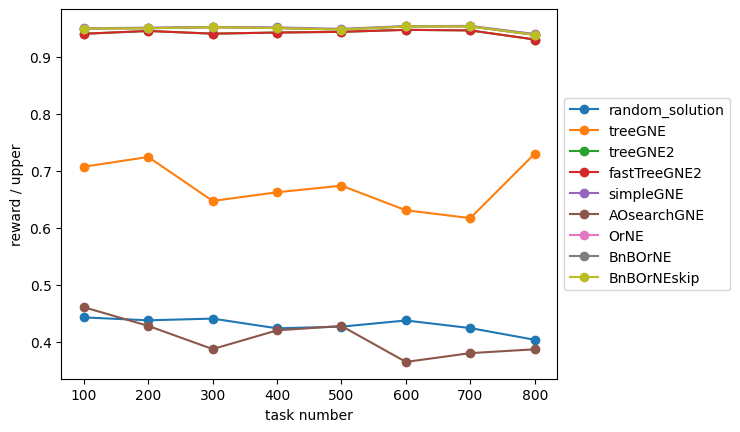

In [38]:
algorithms_mean = [
    # 'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    # 'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]
plot_avg_reward(all_algorithms)

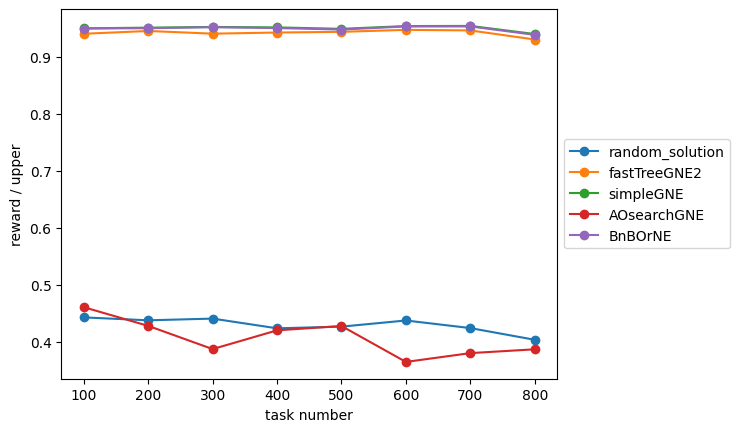

In [39]:
algorithms_mean = [
    'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]
plot_avg_reward(algorithms_mean)

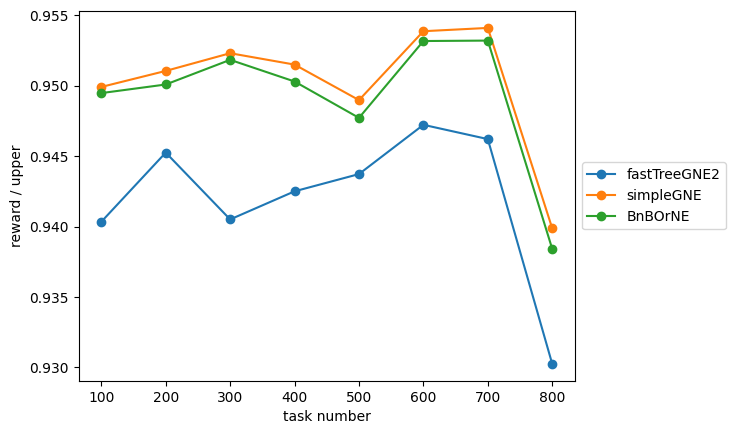

In [40]:
algorithms_mean = [
    # 'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    # 'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]
plot_avg_reward(algorithms_mean)


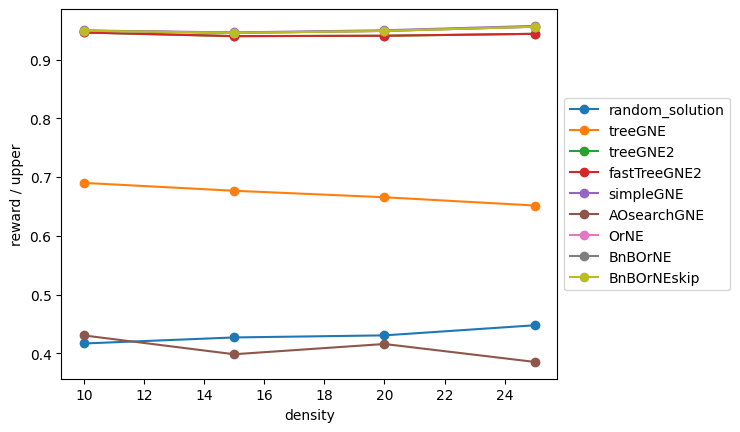

In [41]:
plot_avg_reward(all_algorithms, group_by='t_max_edge', x_label='density')

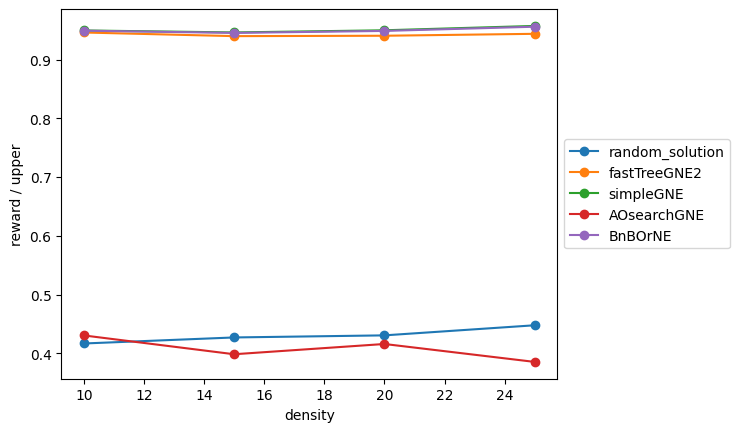

In [42]:
algorithms_mean = [
    'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]
plot_avg_reward(algorithms_mean, group_by='t_max_edge', x_label='density')

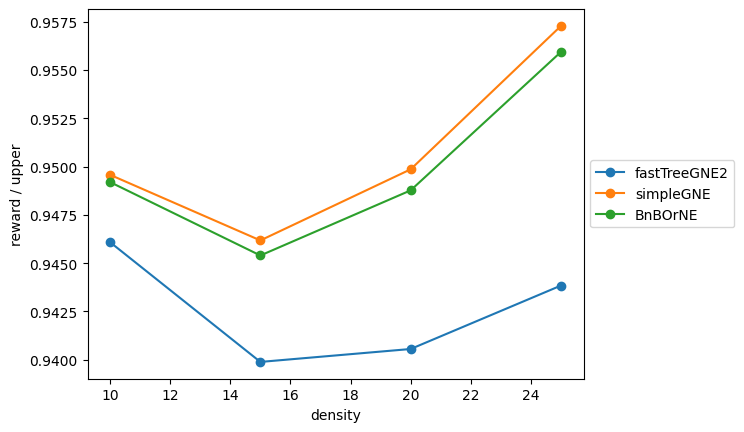

In [43]:
algorithms_mean = [
    # 'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    # 'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]
plot_avg_reward(algorithms_mean, group_by='t_max_edge', x_label='density')

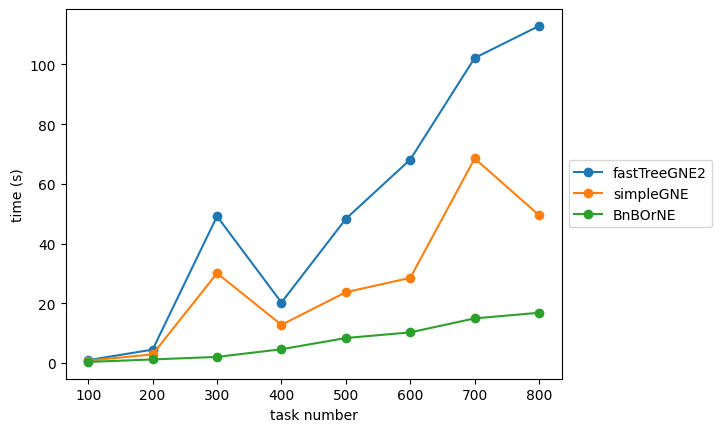

In [44]:
algorithms_mean = [
    # 'random_solution',
    # 'treeGNE', 
    # 'treeGNE2', 
    'fastTreeGNE2', 
    'simpleGNE', 
    # 'AOsearchGNE', 
    # 'OrNE', 
    'BnBOrNE', 
    # 'BnBOrNEskip'
]
plot_avg_time(algorithms_mean)

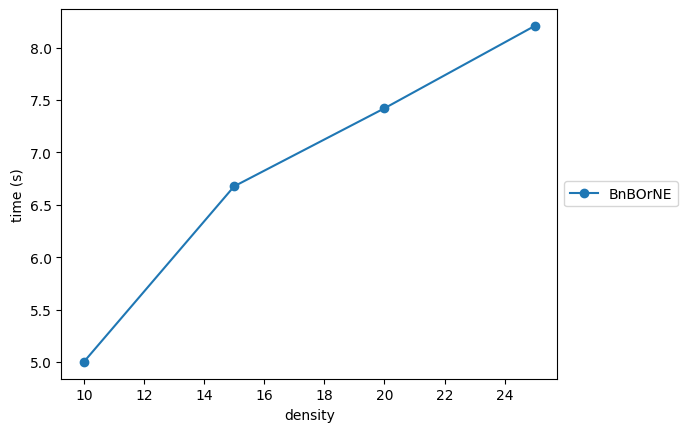

In [45]:
plot_avg_time(['BnBOrNE'], group_by='t_max_edge', x_label='density', flip_y=False)

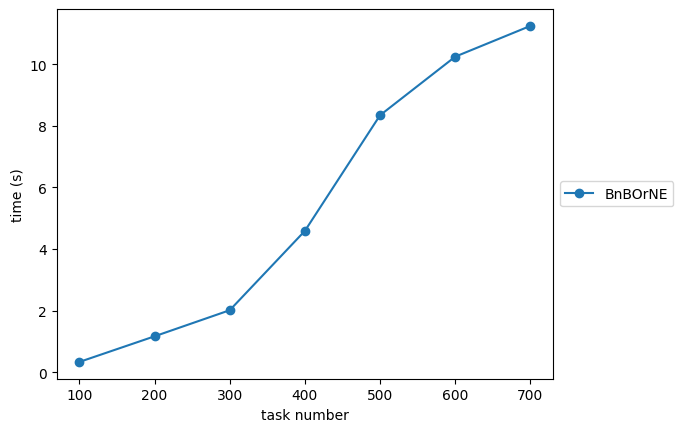

In [16]:
plot_avg_time(['BnBOrNE'], flip_y=False)

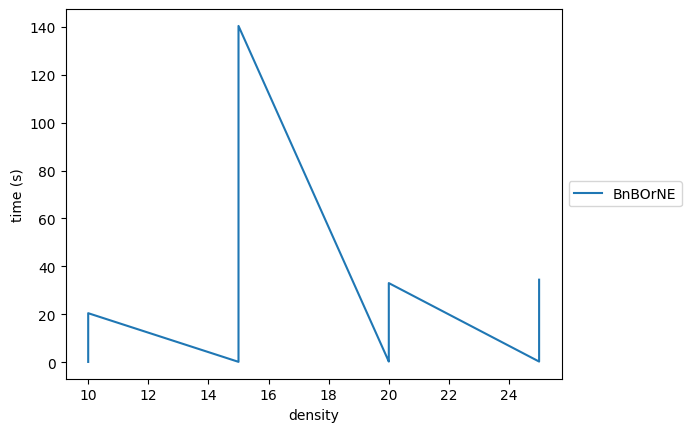

In [17]:
plot_all(['BnBOrNE'], x_category='t_max_edge', x_label='density', y_category='time', y_label='time (s)', flip_y=False)